
#  the model in this file comes from this website

#  https://geertlitjens.nl/post/getting-started-with-camelyon/



#  without editing the model, it is 80% accurate/confident

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications.densenet import DenseNet169, DenseNet201, DenseNet121
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import losses, optimizers, activations, metrics

In [3]:
import tensorflow_datasets as tfds
#download=False - if you dont want to download data again
pcam, pcam_info = tfds.load("patch_camelyon", data_dir='/content/drive/My Drive/Colab Notebooks',download=False, with_info=True) 
print(pcam_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018

In [4]:
'''
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

model.add(Dense(2, activation = "softmax"))

model.compile(optimizer=Adam(0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
model.summary()
'''

'\n#just some network parameters, see above link regarding the layers for details\nkernel_size = (3,3)\npool_size= (2,2)\nfirst_filters = 32\nsecond_filters = 64\nthird_filters = 128\n\n#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end\ndropout_conv = 0.3\ndropout_dense = 0.5\n\n#initialize the model\nmodel = Sequential()\n\n#now add layers to it\n\n#conv block 1\nmodel.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))\nmodel.add(BatchNormalization())\nmodel.add(Activation("relu"))\nmodel.add(Conv2D(first_filters, kernel_size, use_bias=False))\nmodel.add(BatchNormalization())\nmodel.add(Activation("relu"))\nmodel.add(MaxPool2D(pool_size = pool_size)) \nmodel.add(Dropout(dropout_conv))\n\n#conv block 2\nmodel.add(Conv2D(second_filters, kernel_size, use_bias=False))\nmodel.add(BatchNormalization())\nmodel.add(Activation("relu"))\nmodel.add(Conv2D(second_filters, kernel_size, use_bias=False))\nmodel.add(

In [40]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    #model.add(Dense(2, activation='sigmoid'))
    model.add(Dense(2, activation = "softmax"))
    
    sgd_opt = SGD(lr=0.005, momentum=0.01, decay=0.001, nesterov=True)

    model.compile(
        loss='binary_crossentropy',
        optimizer=sgd_opt, #Adam(lr=0.005),
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [0]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.rgb_to_grayscale(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(512).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [0]:
#import tf.keras.callbacks.ModelCheckpoint as ModelCheckpoint
filepath = "weights-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [43]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline, callbacks=callbacks_list,
                 verbose=2, epochs=20, steps_per_epoch=512, validation_steps=256)

Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.85623, saving model to weights-improvement-01-0.86
INFO:tensorflow:Assets written to: weights-improvement-01-0.86/assets


INFO:tensorflow:Assets written to: weights-improvement-01-0.86/assets


512/512 - 350s - loss: 0.3613 - accuracy: 0.8515 - val_loss: 0.3263 - val_accuracy: 0.8562
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.85623
512/512 - 296s - loss: 0.2319 - accuracy: 0.9094 - val_loss: 0.3285 - val_accuracy: 0.8556
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.85623 to 0.85925, saving model to weights-improvement-03-0.86
INFO:tensorflow:Assets written to: weights-improvement-03-0.86/assets


INFO:tensorflow:Assets written to: weights-improvement-03-0.86/assets


512/512 - 354s - loss: 0.2011 - accuracy: 0.9237 - val_loss: 0.3244 - val_accuracy: 0.8593
Epoch 4/20

Epoch 00004: val_accuracy improved from 0.85925 to 0.86105, saving model to weights-improvement-04-0.86
INFO:tensorflow:Assets written to: weights-improvement-04-0.86/assets


INFO:tensorflow:Assets written to: weights-improvement-04-0.86/assets


512/512 - 355s - loss: 0.1832 - accuracy: 0.9312 - val_loss: 0.3281 - val_accuracy: 0.8611
Epoch 5/20

Epoch 00005: val_accuracy improved from 0.86105 to 0.86148, saving model to weights-improvement-05-0.86
INFO:tensorflow:Assets written to: weights-improvement-05-0.86/assets


INFO:tensorflow:Assets written to: weights-improvement-05-0.86/assets


512/512 - 348s - loss: 0.1717 - accuracy: 0.9365 - val_loss: 0.3319 - val_accuracy: 0.8615
Epoch 6/20

Epoch 00006: val_accuracy improved from 0.86148 to 0.86462, saving model to weights-improvement-06-0.86
INFO:tensorflow:Assets written to: weights-improvement-06-0.86/assets


INFO:tensorflow:Assets written to: weights-improvement-06-0.86/assets


512/512 - 354s - loss: 0.1623 - accuracy: 0.9402 - val_loss: 0.3274 - val_accuracy: 0.8646
Epoch 7/20

Epoch 00007: val_accuracy did not improve from 0.86462
512/512 - 296s - loss: 0.1572 - accuracy: 0.9420 - val_loss: 0.3342 - val_accuracy: 0.8636
Epoch 8/20

Epoch 00008: val_accuracy did not improve from 0.86462
512/512 - 290s - loss: 0.1514 - accuracy: 0.9444 - val_loss: 0.3386 - val_accuracy: 0.8631
Epoch 9/20

Epoch 00009: val_accuracy did not improve from 0.86462
512/512 - 295s - loss: 0.1464 - accuracy: 0.9468 - val_loss: 0.3413 - val_accuracy: 0.8634
Epoch 10/20

Epoch 00010: val_accuracy improved from 0.86462 to 0.86481, saving model to weights-improvement-10-0.86
INFO:tensorflow:Assets written to: weights-improvement-10-0.86/assets


INFO:tensorflow:Assets written to: weights-improvement-10-0.86/assets


512/512 - 355s - loss: 0.1426 - accuracy: 0.9484 - val_loss: 0.3407 - val_accuracy: 0.8648
Epoch 11/20

Epoch 00011: val_accuracy did not improve from 0.86481
512/512 - 296s - loss: 0.1396 - accuracy: 0.9499 - val_loss: 0.3447 - val_accuracy: 0.8640
Epoch 12/20

Epoch 00012: val_accuracy did not improve from 0.86481
512/512 - 294s - loss: 0.1368 - accuracy: 0.9509 - val_loss: 0.3459 - val_accuracy: 0.8641
Epoch 13/20

Epoch 00013: val_accuracy did not improve from 0.86481
512/512 - 297s - loss: 0.1334 - accuracy: 0.9523 - val_loss: 0.3491 - val_accuracy: 0.8636
Epoch 14/20

Epoch 00014: val_accuracy did not improve from 0.86481
512/512 - 297s - loss: 0.1310 - accuracy: 0.9526 - val_loss: 0.3522 - val_accuracy: 0.8631
Epoch 15/20

Epoch 00015: val_accuracy did not improve from 0.86481
512/512 - 296s - loss: 0.1300 - accuracy: 0.9534 - val_loss: 0.3546 - val_accuracy: 0.8631
Epoch 16/20

Epoch 00016: val_accuracy did not improve from 0.86481
512/512 - 294s - loss: 0.1267 - accuracy: 0.95

In [44]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=256, verbose=0)[1]))

Test set accuracy is 0.8218


In [45]:
model.save("./patchcamelyon_dense_sgd_005_v1.hf5")

INFO:tensorflow:Assets written to: ./patchcamelyon_dense_sgd_005_v1.hf5/assets


INFO:tensorflow:Assets written to: ./patchcamelyon_dense_sgd_005_v1.hf5/assets


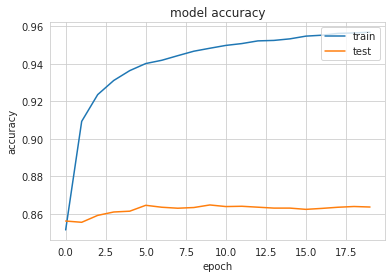

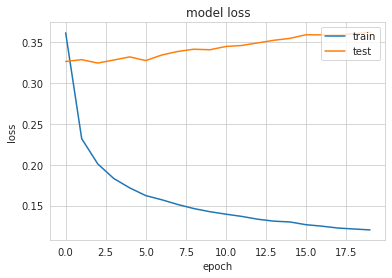

In [46]:
hist2=hist
plt.figure()
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
%matplotlib inline
sns.set_style("whitegrid")
np.random.seed(697)

In [52]:
# Code below from https://www.kaggle.com/georsara1/95-auc-score-in-train-sample-with-neural-nets

#Predict on test set
predictions_NN_prob = model.predict(test_pipeline)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob > 0.5, 0, 1) #Turn probability to 0-1 binary output

y_numpy = pcam['test'].as_numpy_iterator()
test_y = np.array([i['label'] for i in y_numpy])

#Print accuracy
acc_NN = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.82177734375


[0 1 0 ... 1 1 0]


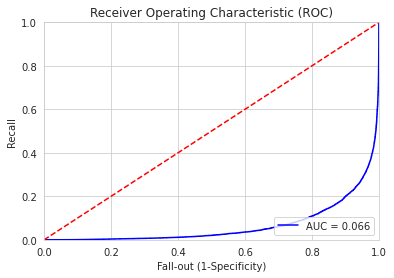

In [53]:

#Print Area Under Curve

print(test_y)
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

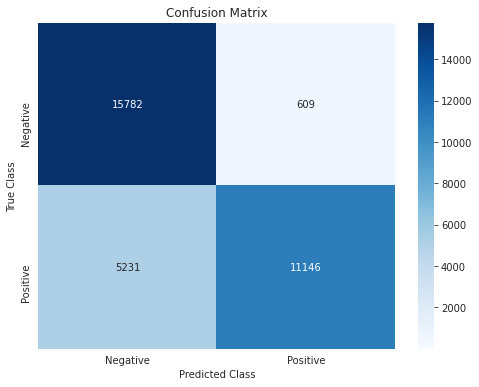

In [56]:
#Print Confusion Matrix
cm = confusion_matrix(test_y, predictions_NN_01)
labels = ['Negative', 'Positive']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()